In [24]:
# This file generates the data for Figure #4 from the paper https://arxiv.org/pdf/1806.06975.pdf

import os 
import sys
import pickle
import argparse
import networkx as nx
import operator

import pandas as pd
import numpy as np

import itertools
import sklearn
import torch
import datetime
import matplotlib, matplotlib.pyplot as plt
from collections import defaultdict

from torch.autograd import Variable
from models.model_wrapper import MLP
from data import datasets
from data.gene_graphs import GeneManiaGraph, RegNetGraph
from data.utils import record_result


In [32]:
graphs = {"regnet": RegNetGraph(), "genemania": GeneManiaGraph()}


Torrent name: regnet.pkl, Size: 8.81MB
Checking for pieces on disk: |██████████████████████████████████████████████████| 100.0% 
Found 269 finished pieces out of 269 total pieces.
Found dataset at /Users/martinweiss/.academictorrents-datastore/regnet.pkl
Torrent name: genemania.pkl, Size: 9.61MB
Checking for pieces on disk: |██████████████████████████████████████████████████| 100.0% 
Found 294 finished pieces out of 294 total pieces.
Found dataset at /Users/martinweiss/.academictorrents-datastore/genemania.pkl


In [33]:
# Setup the results dictionary
filename = "experiments/results/graph-gen.pkl"
try:
    results = pickle.load(open(filename, "rb"), encoding='latin1')
    print("Loaded Checkpointed Results")
except Exception as e:
    print(e)
    results = pd.DataFrame(columns=['auc', 'gene', 'model', 'graph', 'is_first_degree', 'seed', 'train_size', 'optimize_graph_results'])
    print("Created a New Results Dictionary")


Loaded Checkpointed Results


In [5]:
train_size = 50
test_size = 1000
trials = 3
cuda = False
models = {"BasicMLP": MLP(column_names=dataset.df.columns, dropout=False, cuda=cuda)}


In [8]:
# Create the set of all experiment ids and see which are left to do
columns = ["gene", "graph", "model", "seed", "is_first_degree", "train_size"]
all_exp_ids = [x for x in itertools.product(dataset.df.columns, graphs.keys(), models.keys(), range(trials), [True, False], [train_size])]
all_exp_ids = pd.DataFrame(all_exp_ids, columns=columns)
all_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in all_exp_ids.itertuples(name=None)]
results_exp_ids = results[columns].copy()
results_exp_ids.index = ["-".join(map(str, tup[1:])) for tup in results_exp_ids.itertuples(name=None)]
intersection_ids = all_exp_ids.index.intersection(results_exp_ids.index)
todo = all_exp_ids.drop(intersection_ids).to_dict(orient="records")

print("todo: " + str(len(todo)))
print("done: " + str(len(results)))

todo: 195600
done: 0


In [15]:
def optimize_graph(model, gene_graph, gene, X_train, X_test, y_train, y_test):
    neighbors = list(gene_graph.first_degree(gene)[0])
    neighbors = [n for n in neighbors if n in X_train.columns.values]
    res = {}
    for neighbor in neighbors:
        candidate_nodes = neighbors if gene == neighbor else set(neighbors) - set(neighbor)
        x_train = X_train.loc[:, candidate_nodes].copy()
        x_test = X_test.loc[:, candidate_nodes].copy()
        x_train[gene] = 1
        x_test[gene] = 1

        try:
            model.fit(x_train, y_train)
            x_test = Variable(torch.FloatTensor(np.expand_dims(x_test.values, axis=2)), requires_grad=False).float()
            if cuda:
                x_test = x_test.cuda()
            y_hat = model.predict(x_test)[:, 1].data.cpu().numpy()
            auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())
            res[neighbor] = auc
            model.best_model = None # cleanup

        except Exception as e:
            print(e)
    return res


In [17]:
optimize_graph_results = []

for row in todo:
    if len(results) % 10 == 0:
        print(len(results))
    gene = row["gene"]
    graph_name = row["graph"]
    model_name = row["model"]
    seed = row["seed"]
    is_first_degree = row["is_first_degree"]
    model = models[model_name]

    experiment = {
        "gene": gene,
        "model": model_name,
        "graph": graph_name,
        "is_first_degree": is_first_degree,
        "seed": seed,
        "train_size": train_size,
        "optimize_graph_results": None,
    }
    dataset.labels = dataset.df[gene].where(dataset.df[gene] > 0).notnull().astype("int")
    try:
        X_train, X_test, y_train, y_test = sklearn.model_selection.\
            train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, 
                             train_size=train_size, test_size=test_size)
    except ValueError:
        results = record_result(results, experiment, filename)
        continue

    if is_first_degree:
        gene_graph = graphs[graph_name]
        experiment["optimize_graph_results"] = optimize_graph(model, gene_graph, gene, X_train, X_test, y_train, y_test)
    else:
        X_train = X_train.copy()
        X_test = X_test.copy()

        X_train[gene] = 1
        X_test[gene] = 1

        try:
            model.fit(X_train, y_train)

            x_test = Variable(torch.FloatTensor(np.expand_dims(X_test.values, axis=2)), requires_grad=False).float()
            if cuda:
                x_test = x_test.cuda()
            y_hat = model.predict(x_test)[:, 1].data.cpu().numpy()
            auc = sklearn.metrics.roc_auc_score(y_test, np.asarray(y_hat).flatten())
            model.best_model = None # cleanup
            experiment["auc"] = auc
        except Exception as e:
            print(e)
    results = record_result(results, experiment, filename)


40
50
60
70
80
90
'NoneType' object has no attribute 'copy'
100
110
120
130
140
150
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in that case.
Only one class present in y_true. ROC AUC score is not defined in tha

KeyboardInterrupt: 

In [18]:
results

,auc,gene,model,graph,is_first_degree,seed,train_size,optimize_graph_results
0,NaN,UBE2Q1,BasicMLP,genemania,True,0,50,"{'KIAA0368': 0.5150952704451346, 'RNF26': 0.61..."
1,0.704233,UBE2Q1,BasicMLP,genemania,False,0,50,None
2,NaN,UBE2Q1,BasicMLP,genemania,True,1,50,"{'KIAA0368': 0.5278936982401656, 'RNF26': 0.57..."
3,0.644115,UBE2Q1,BasicMLP,genemania,False,1,50,None
4,NaN,UBE2Q1,BasicMLP,genemania,True,2,50,"{'KIAA0368': 0.4436626552795031, 'RNF26': 0.46..."
5,0.673705,UBE2Q1,BasicMLP,genemania,False,2,50,None
6,NaN,UBE2Q1,BasicMLP,regnet,True,0,50,"{'POLR3C': 0.7879989971532091, 'ARL3': 0.75818..."
7,0.692846,UBE2Q1,BasicMLP,regnet,False,0,50,None
8,NaN,UBE2Q1,BasicMLP,regnet,True,1,50,"{'POLR3C': 0.8241783126293996, 'ARL3': 0.81399..."
9,0.622473,UBE2Q1,BasicMLP,regnet,False,1,50,None


In [ ]:
results[results["is_first_degree"] == True]

In [8]:
# Compare the performance of each graph at predicting their neighbors
df = results

first_degree = df[df['is_first_degree'] == True][
    df['graph'] == 'genemania'].groupby(['gene', 'model', 'train_size'])['auc'].agg(['mean', 'std'])
full = df[df['is_first_degree'] == False][
    df['graph'] == 'genemania'].groupby(['gene','model', 'train_size'])['auc'].agg(['mean', 'std'])
genemania_df = first_degree.sub(full).sort_values('mean', ascending=False)

first_degree = df[df['is_first_degree'] == True][
    df['graph'] == 'regnet'].groupby(['gene', 'model', 'train_size'])['auc'].agg(['mean', 'std'])
full = df[df['is_first_degree'] == False][
    df['graph'] == 'regnet'].groupby(['gene','model', 'train_size'])['auc'].agg(['mean', 'std'])
regnet_df = first_degree.sub(full).sort_values('mean', ascending=False)


/home/martin/code/academic/gene-graph-conv/venv/lib/python3.5/site-packages/ipykernel_launcher.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """
/home/martin/code/academic/gene-graph-conv/venv/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys
/home/martin/code/academic/gene-graph-conv/venv/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # This is added back by InteractiveShellApp.init_path()
/home/martin/code/academic/gene-graph-conv/venv/lib/python3.5/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


/home/martin/code/academic/gene-graph-conv/venv/lib/python3.5/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/martin/code/academic/gene-graph-conv/venv/lib/python3.5/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


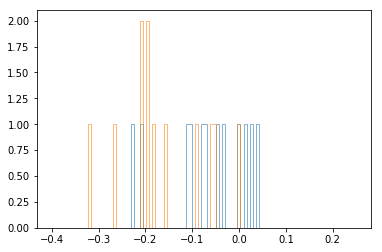

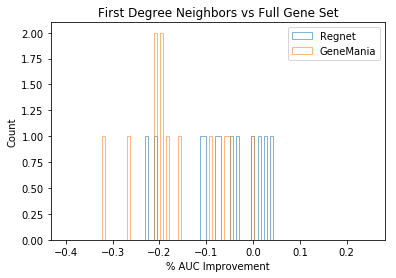

In [9]:

l1 = genemania_df['mean']
l2 = regnet_df['mean']

fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, range=(-.4, .25), bins=100, label="Regnet", 
                              density=0, alpha=0.55, histtype='step')
n1, bins1, patches1 = ax.hist(l2, range=(-.4, .25), bins=100, label="GeneMania", 
                              density=0, alpha=0.55, histtype='step')


fig, ax = plt.subplots()
n1, bins1, patches1 = ax.hist(l1, range=(-.4, .25), bins=100, label="Regnet", 
                              density=0, alpha=0.55, histtype='step')
n1, bins1, patches1 = ax.hist(l2, range=(-.4, .25), bins=100, label="GeneMania", 
                              density=0, alpha=0.55, histtype='step')

plt.title("First Degree Neighbors vs Full Gene Set")
plt.ylabel("Count")
plt.xlabel("% AUC Improvement")

plt.legend()
plt.show()